# Trabalho 1
Matéria: Processamento de Linguagem Natural <br>
Dupla/Matrícula: Bianca Nunes Coelho - 15102880, Raíssa Nunes Coelho - 15102887 <br> 

## Introdução

Multi Class Classification <br>

## Bibliotecas
Bibliotecas do ptyhon utilizadas neste trabalho estão a seguir.

In [1]:
import pandas as pd
import re
import nltk
import spacy
import gensim
import matplotlib.pyplot as plt

## Datasets
Datasets utilizados estão definidos a seguir.

In [2]:
file = "train-00000-of-00001-ecf072e7202447d8.parquet"
df = pd.read_parquet(file, engine= 'pyarrow')

In [3]:
len(df)

3877

In [4]:
df.head(4)

,titulo,texto,link,resumo,categoria,data_hora
0,"Veja a trajetória de Fernando Diniz, em busca ...",Se tem um treinador que sempre foi badalado pe...,https://www.cnnbrasil.com.br/esportes/veja-a-t...,Técnico tricolor e da Seleção Brasileira tem a...,esportes,2023-11-04 12:26:18
1,"Após tempestade com ventos, São Paulo terá sáb...",Após uma tempestade com ventos de mais de 100 ...,https://www.cnnbrasil.com.br/nacional/apos-tem...,"Termômetros devem chegar a 26ºC, esquentando a...",nacional,2023-11-04 12:15:44
2,Como os aplicativos de relacionamento “arruina...,Jenny Nguyen-Don estava com vontade de comer f...,https://www.cnnbrasil.com.br/tecnologia/como-o...,Pessoas em busca de relacionamentos afirmam qu...,tecnologia,2023-11-04 12:15:07
3,Fluminense pode ser o 26º clube a levantar a t...,O Fluminense vai em busca do primeiro título d...,https://www.cnnbrasil.com.br/esportes/fluminen...,"Em busca do título inédito, o Tricolor carioca...",esportes,2023-11-04 12:05:24


## Balanceamento

In [5]:
df['categoria'].value_counts()

categoria
esportes           960
nacional           623
internacional      618
economia           562
politica           507
entretenimento     450
tecnologia          44
saude               41
noticias            38
lifestyle           21
branded-content     13
Name: count, dtype: int64

<Axes: xlabel='categoria'>

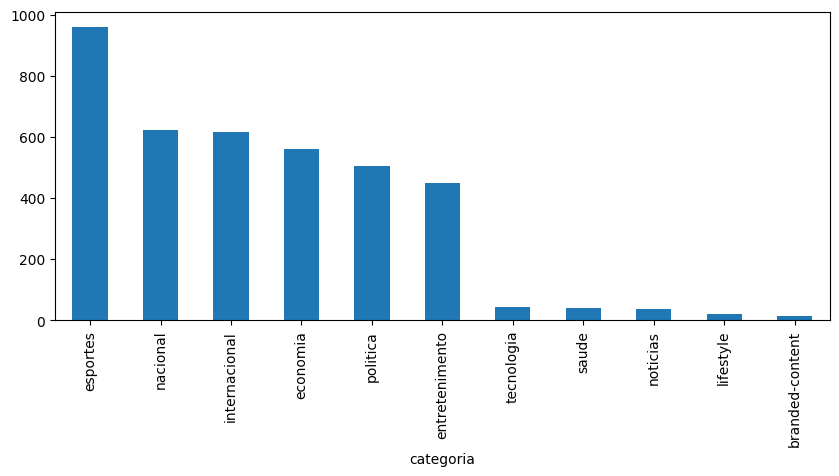

In [6]:
plt.figure(figsize=(10,4))
df.categoria.value_counts().plot(kind='bar')

In [7]:
indice_linha_remover = ['tecnologia',  'saude','noticias','lifestyle','branded-content']

In [8]:
df = df[~df['categoria'].isin(indice_linha_remover)]

In [9]:
df['categoria'].value_counts()

categoria
esportes          960
nacional          623
internacional     618
economia          562
politica          507
entretenimento    450
Name: count, dtype: int64

In [10]:
# Undersampling
min = df['categoria'].value_counts().min()

amostras = []

for i in df['categoria'].value_counts().index:
    a = df[df['categoria'] == i].sample(min, replace=False)
    amostras.append(a)

df_balanceado = pd.concat(amostras)

In [11]:
df_balanceado['categoria'].value_counts()

categoria
esportes          450
nacional          450
internacional     450
economia          450
politica          450
entretenimento    450
Name: count, dtype: int64

In [12]:
df_balanceado = df_balanceado.reset_index(drop=True)
df_balanceado.head(5)

,titulo,texto,link,resumo,categoria,data_hora
0,Vídeo: Bastidores da vitória do Palmeiras sobr...,"O Palmeiras fez história no Nilton Santos, na ...",https://www.cnnbrasil.com.br/esportes/video-ba...,Verdão bateu o Glorioso de virada após estar p...,esportes,2023-11-03 19:51:33
1,"Al-Ahli, de Firmino, tropeça fora de casa e se...",Quatro confrontos deram início nesta quinta-fe...,https://www.cnnbrasil.com.br/esportes/al-ahli-...,"Al-Ahli empatou com o Dhamk por 2 a 2, nesta q...",esportes,2023-11-09 22:08:30
2,Por que Kim Kardashian “surtou” ao encontrar E...,"Nos últimos meses, a socialite Kim Kardashian ...",https://www.cnnbrasil.com.br/esportes/por-que-...,"Socialite leva o filho, Saint West, a vários j...",esportes,2023-11-16 19:10:33
3,Londrina x Novorizontino: tempo real e onde as...,,https://www.cnnbrasil.com.br/esportes/londrina...,Onde assistir e tempo real dos lances e das es...,esportes,2023-11-17 14:46:51
4,Entenda por que a torcida do Celta de Vigo que...,"Em campanha conjunta nas redes sociais, torced...",https://www.cnnbrasil.com.br/esportes/entenda-...,Time espanhol que disputa LALIGA tem sofrido c...,esportes,2023-11-08 21:27:38


In [13]:
df_balanceado2 = df_balanceado.copy()
df_balanceado3 = df_balanceado.copy()

In [14]:
df_balanceado2.head()

,titulo,texto,link,resumo,categoria,data_hora
0,Vídeo: Bastidores da vitória do Palmeiras sobr...,"O Palmeiras fez história no Nilton Santos, na ...",https://www.cnnbrasil.com.br/esportes/video-ba...,Verdão bateu o Glorioso de virada após estar p...,esportes,2023-11-03 19:51:33
1,"Al-Ahli, de Firmino, tropeça fora de casa e se...",Quatro confrontos deram início nesta quinta-fe...,https://www.cnnbrasil.com.br/esportes/al-ahli-...,"Al-Ahli empatou com o Dhamk por 2 a 2, nesta q...",esportes,2023-11-09 22:08:30
2,Por que Kim Kardashian “surtou” ao encontrar E...,"Nos últimos meses, a socialite Kim Kardashian ...",https://www.cnnbrasil.com.br/esportes/por-que-...,"Socialite leva o filho, Saint West, a vários j...",esportes,2023-11-16 19:10:33
3,Londrina x Novorizontino: tempo real e onde as...,,https://www.cnnbrasil.com.br/esportes/londrina...,Onde assistir e tempo real dos lances e das es...,esportes,2023-11-17 14:46:51
4,Entenda por que a torcida do Celta de Vigo que...,"Em campanha conjunta nas redes sociais, torced...",https://www.cnnbrasil.com.br/esportes/entenda-...,Time espanhol que disputa LALIGA tem sofrido c...,esportes,2023-11-08 21:27:38


In [15]:
df_balanceado3.head()

,titulo,texto,link,resumo,categoria,data_hora
0,Vídeo: Bastidores da vitória do Palmeiras sobr...,"O Palmeiras fez história no Nilton Santos, na ...",https://www.cnnbrasil.com.br/esportes/video-ba...,Verdão bateu o Glorioso de virada após estar p...,esportes,2023-11-03 19:51:33
1,"Al-Ahli, de Firmino, tropeça fora de casa e se...",Quatro confrontos deram início nesta quinta-fe...,https://www.cnnbrasil.com.br/esportes/al-ahli-...,"Al-Ahli empatou com o Dhamk por 2 a 2, nesta q...",esportes,2023-11-09 22:08:30
2,Por que Kim Kardashian “surtou” ao encontrar E...,"Nos últimos meses, a socialite Kim Kardashian ...",https://www.cnnbrasil.com.br/esportes/por-que-...,"Socialite leva o filho, Saint West, a vários j...",esportes,2023-11-16 19:10:33
3,Londrina x Novorizontino: tempo real e onde as...,,https://www.cnnbrasil.com.br/esportes/londrina...,Onde assistir e tempo real dos lances e das es...,esportes,2023-11-17 14:46:51
4,Entenda por que a torcida do Celta de Vigo que...,"Em campanha conjunta nas redes sociais, torced...",https://www.cnnbrasil.com.br/esportes/entenda-...,Time espanhol que disputa LALIGA tem sofrido c...,esportes,2023-11-08 21:27:38


In [16]:
# pega coluna
text = df_balanceado['texto'] # para NLTK
text2 = df_balanceado2['texto'] # para spaCy
text3 = df_balanceado3['texto'] # para Gensim
len(text)

2700

In [17]:
text[0]

'O Palmeiras fez história no Nilton Santos, na última quarta-feira (1º). A partida contra o Botafogo era vista como uma final do Campeonato Brasileiro. Apesar de não ter decidido o futuro de nenhum dos times, a vitória de virada, com quatro gols na etapa final após sair perdendo por 3 a 0, encheu o time de Abel Ferreira de confiança para a reta final da Série A.  Leia mais  Nos bastidores divulgados pela Palmeiras TV, o torcedor pôde acompanhar todo o clima no intervalo, a conversa de Abel com o elenco, a virada liderada por Endrick e a saída do estádio ao som de “provocação” com o funk do Segovinha. Assista abaixo. Este conteúdo foi criado originalmente em Itatiaia. versão original'

In [18]:
categorias = ['esportes','nacional', 'internacional', 'economia', 'politica', 'entretenimento']

## Pré-processamento

### NLTK

In [19]:
for i in range(len(text)):
    text[i] = text[i].lower()

In [20]:
from unidecode import unidecode

for i in range(len(text)):
    text[i] = unidecode(text[i])

In [21]:
for i in range(len(text)):
    text[i] = re.sub(r'[^a-zA-Z\s]', "" ,text[i])

In [22]:
print(text[0])

o palmeiras fez historia no nilton santos na ultima quartafeira o a partida contra o botafogo era vista como uma final do campeonato brasileiro apesar de nao ter decidido o futuro de nenhum dos times a vitoria de virada com quatro gols na etapa final apos sair perdendo por  a  encheu o time de abel ferreira de confianca para a reta final da serie a  leia mais  nos bastidores divulgados pela palmeiras tv o torcedor pode acompanhar todo o clima no intervalo a conversa de abel com o elenco a virada liderada por endrick e a saida do estadio ao som de provocacao com o funk do segovinha assista abaixo este conteudo foi criado originalmente em itatiaia versao original


In [23]:
token_text = []

for j in text:
    token_text.append(nltk.word_tokenize(j))

In [24]:
print(token_text[0])

['o', 'palmeiras', 'fez', 'historia', 'no', 'nilton', 'santos', 'na', 'ultima', 'quartafeira', 'o', 'a', 'partida', 'contra', 'o', 'botafogo', 'era', 'vista', 'como', 'uma', 'final', 'do', 'campeonato', 'brasileiro', 'apesar', 'de', 'nao', 'ter', 'decidido', 'o', 'futuro', 'de', 'nenhum', 'dos', 'times', 'a', 'vitoria', 'de', 'virada', 'com', 'quatro', 'gols', 'na', 'etapa', 'final', 'apos', 'sair', 'perdendo', 'por', 'a', 'encheu', 'o', 'time', 'de', 'abel', 'ferreira', 'de', 'confianca', 'para', 'a', 'reta', 'final', 'da', 'serie', 'a', 'leia', 'mais', 'nos', 'bastidores', 'divulgados', 'pela', 'palmeiras', 'tv', 'o', 'torcedor', 'pode', 'acompanhar', 'todo', 'o', 'clima', 'no', 'intervalo', 'a', 'conversa', 'de', 'abel', 'com', 'o', 'elenco', 'a', 'virada', 'liderada', 'por', 'endrick', 'e', 'a', 'saida', 'do', 'estadio', 'ao', 'som', 'de', 'provocacao', 'com', 'o', 'funk', 'do', 'segovinha', 'assista', 'abaixo', 'este', 'conteudo', 'foi', 'criado', 'originalmente', 'em', 'itatiaia'

In [25]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/raissa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [26]:
from nltk.corpus import stopwords
sw = stopwords.words('portuguese')

In [27]:
for stop in sw:
    for text in token_text:
        for t in text:
            if(t == stop):
                text.remove(t)

In [28]:
print(token_text[0])

['palmeiras', 'fez', 'historia', 'nilton', 'santos', 'ultima', 'quartafeira', 'partida', 'contra', 'botafogo', 'vista', 'final', 'campeonato', 'brasileiro', 'apesar', 'nao', 'ter', 'decidido', 'futuro', 'nenhum', 'times', 'vitoria', 'virada', 'quatro', 'gols', 'etapa', 'final', 'apos', 'sair', 'perdendo', 'encheu', 'time', 'abel', 'ferreira', 'confianca', 'reta', 'final', 'serie', 'leia', 'bastidores', 'divulgados', 'palmeiras', 'tv', 'torcedor', 'pode', 'acompanhar', 'todo', 'clima', 'intervalo', 'conversa', 'abel', 'elenco', 'virada', 'liderada', 'endrick', 'saida', 'estadio', 'som', 'provocacao', 'funk', 'segovinha', 'assista', 'abaixo', 'conteudo', 'criado', 'originalmente', 'itatiaia', 'versao', 'original']


In [29]:
df_balanceado['texto'] = token_text
df_balanceado.head(2)

,titulo,texto,link,resumo,categoria,data_hora
0,Vídeo: Bastidores da vitória do Palmeiras sobr...,"[palmeiras, fez, historia, nilton, santos, ult...",https://www.cnnbrasil.com.br/esportes/video-ba...,Verdão bateu o Glorioso de virada após estar p...,esportes,2023-11-03 19:51:33
1,"Al-Ahli, de Firmino, tropeça fora de casa e se...","[quatro, confrontos, deram, inicio, nesta, qui...",https://www.cnnbrasil.com.br/esportes/al-ahli-...,"Al-Ahli empatou com o Dhamk por 2 a 2, nesta q...",esportes,2023-11-09 22:08:30


### spaCy

In [30]:
for i in range(len(text2)):
    text2[i] = text2[i].lower()

In [31]:
from unidecode import unidecode

for i in range(len(text2)):
    text2[i] = unidecode(text2[i])

In [32]:
for i in range(len(text2)):
   text2[i] = re.sub(r'[^a-zA-Z\s]', "" ,text2[i])

In [33]:
print(text2[0])

o palmeiras fez historia no nilton santos na ultima quartafeira o a partida contra o botafogo era vista como uma final do campeonato brasileiro apesar de nao ter decidido o futuro de nenhum dos times a vitoria de virada com quatro gols na etapa final apos sair perdendo por  a  encheu o time de abel ferreira de confianca para a reta final da serie a  leia mais  nos bastidores divulgados pela palmeiras tv o torcedor pode acompanhar todo o clima no intervalo a conversa de abel com o elenco a virada liderada por endrick e a saida do estadio ao som de provocacao com o funk do segovinha assista abaixo este conteudo foi criado originalmente em itatiaia versao original


In [34]:
nlp = spacy.load('pt_core_news_sm')

doc = []

for j in text2:
    temp = nlp(j)
    doc.append(temp)
print(doc[0])

o palmeiras fez historia no nilton santos na ultima quartafeira o a partida contra o botafogo era vista como uma final do campeonato brasileiro apesar de nao ter decidido o futuro de nenhum dos times a vitoria de virada com quatro gols na etapa final apos sair perdendo por  a  encheu o time de abel ferreira de confianca para a reta final da serie a  leia mais  nos bastidores divulgados pela palmeiras tv o torcedor pode acompanhar todo o clima no intervalo a conversa de abel com o elenco a virada liderada por endrick e a saida do estadio ao som de provocacao com o funk do segovinha assista abaixo este conteudo foi criado originalmente em itatiaia versao original


In [35]:
token_text2 = []

#Creating and updating our list of tokens using list comprehension 
for i in range(len(text2)):
    temp = [token.text for token in doc[i] if not token.is_space]
    token_text2.append(temp)

print(token_text2[0])

['o', 'palmeiras', 'fez', 'historia', 'no', 'nilton', 'santos', 'na', 'ultima', 'quartafeira', 'o', 'a', 'partida', 'contra', 'o', 'botafogo', 'era', 'vista', 'como', 'uma', 'final', 'do', 'campeonato', 'brasileiro', 'apesar', 'de', 'nao', 'ter', 'decidido', 'o', 'futuro', 'de', 'nenhum', 'dos', 'times', 'a', 'vitoria', 'de', 'virada', 'com', 'quatro', 'gols', 'na', 'etapa', 'final', 'apos', 'sair', 'perdendo', 'por', 'a', 'encheu', 'o', 'time', 'de', 'abel', 'ferreira', 'de', 'confianca', 'para', 'a', 'reta', 'final', 'da', 'serie', 'a', 'leia', 'mais', 'nos', 'bastidores', 'divulgados', 'pela', 'palmeiras', 'tv', 'o', 'torcedor', 'pode', 'acompanhar', 'todo', 'o', 'clima', 'no', 'intervalo', 'a', 'conversa', 'de', 'abel', 'com', 'o', 'elenco', 'a', 'virada', 'liderada', 'por', 'endrick', 'e', 'a', 'saida', 'do', 'estadio', 'ao', 'som', 'de', 'provocacao', 'com', 'o', 'funk', 'do', 'segovinha', 'assista', 'abaixo', 'este', 'conteudo', 'foi', 'criado', 'originalmente', 'em', 'itatiaia'

In [36]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop = STOP_WORDS
#print(stop)

In [37]:
token2 = []
for i in token_text2:
    temp = []
    for token in i:
        if token not in stop:
            temp.append(token)
    token2.append(temp)
print(token2[0])

['palmeiras', 'historia', 'nilton', 'santos', 'ultima', 'quartafeira', 'partida', 'botafogo', 'vista', 'campeonato', 'brasileiro', 'apesar', 'nao', 'decidido', 'futuro', 'nenhum', 'times', 'vitoria', 'virada', 'gols', 'etapa', 'apos', 'sair', 'perdendo', 'encheu', 'time', 'abel', 'ferreira', 'confianca', 'reta', 'serie', 'leia', 'bastidores', 'divulgados', 'palmeiras', 'tv', 'torcedor', 'acompanhar', 'clima', 'intervalo', 'conversa', 'abel', 'elenco', 'virada', 'liderada', 'endrick', 'saida', 'estadio', 'som', 'provocacao', 'funk', 'segovinha', 'assista', 'abaixo', 'conteudo', 'criado', 'originalmente', 'itatiaia', 'versao', 'original']


In [38]:
df_balanceado2['texto'] = token2
df_balanceado2.head(2)

,titulo,texto,link,resumo,categoria,data_hora
0,Vídeo: Bastidores da vitória do Palmeiras sobr...,"[palmeiras, historia, nilton, santos, ultima, ...",https://www.cnnbrasil.com.br/esportes/video-ba...,Verdão bateu o Glorioso de virada após estar p...,esportes,2023-11-03 19:51:33
1,"Al-Ahli, de Firmino, tropeça fora de casa e se...","[confrontos, deram, quintafeira, rodada, campe...",https://www.cnnbrasil.com.br/esportes/al-ahli-...,"Al-Ahli empatou com o Dhamk por 2 a 2, nesta q...",esportes,2023-11-09 22:08:30


### Gensim

In [39]:
from gensim.utils import simple_preprocess
from gensim.utils import tokenize

In [40]:
for i in range(len(text3)):
   text3[i] = re.sub(r'[^a-zA-Z\s]', "" ,text3[i])

In [41]:
for i in range(len(text3)):
    text3[i] = simple_preprocess(text3[i], deacc=True, min_len=3)

In [42]:
stopwords = [ 'a', 'à', 'adeus', 'agora', 'aí', 'ainda', 'além', 'algo', 'alguém', 'algum', 'alguma', 'algumas', 'alguns', 'ali', 'ampla', 'amplas', 'amplo', 'amplos', 'ano', 'anos', 'ante', 'antes', 'ao', 'aos', 'apenas', 'apoio', 'após', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aqui', 'aquilo', 'área', 'as', 'às', 'assim', 'até', 'atrás', 'através', 'baixo', 'bastante', 'bem', 'boa', 'boas', 'bom', 'bons', 'breve', 'cá', 'cada', 'catorze', 'cedo', 'cento', 'certamente', 'certeza', 'cima', 'cinco', 'coisa', 'coisas', 'com', 'como', 'conselho', 'contra', 'contudo', 'custa', 'da', 'dá', 'dão', 'daquela', 'daquelas', 'daquele', 'daqueles', 'dar', 'das', 'de', 'debaixo', 'dela', 'delas', 'dele', 'deles', 'demais', 'dentro', 'depois', 'desde', 'dessa', 'dessas', 'desse', 'desses', 'desta', 'destas', 'deste', 'destes', 'deve', 'devem', 'devendo', 'dever', 'deverá', 'deverão', 'deveria', 'deveriam', 'devia', 'deviam', 'dez', 'dezanove', 'dezasseis', 'dezassete', 'dezoito', 'dia', 'diante', 'disse', 'disso', 'disto', 'dito', 'diz', 'dizem', 'dizer', 'do', 'dois', 'dos', 'doze', 'duas', 'dúvida', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'embora', 'enquanto', 'entre', 'era', 'eram', 'éramos', 'és', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estás', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estiveste', 'estivestes', 'estou', 'etc', 'eu', 'exemplo', 'faço', 'falta', 'favor', 'faz', 'fazeis', 'fazem', 'fazemos', 'fazendo', 'fazer', 'fazes', 'feita', 'feitas', 'feito', 'feitos', 'fez', 'fim', 'final', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'forma', 'formos', 'fosse', 'fossem', 'fôssemos', 'foste', 'fostes', 'fui', 'geral', 'grande', 'grandes', 'grupo', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'havia', 'hei', 'hoje', 'hora', 'horas', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvéssemos', 'isso', 'isto', 'já', 'la', 'lá', 'lado', 'lhe', 'lhes', 'lo', 'local', 'logo', 'longe', 'lugar', 'maior', 'maioria', 'mais', 'mal', 'mas', 'máximo', 'me', 'meio', 'menor', 'menos', 'mês', 'meses', 'mesma', 'mesmas', 'mesmo', 'mesmos', 'meu', 'meus', 'mil', 'minha', 'minhas', 'momento', 'muita', 'muitas', 'muito', 'muitos', 'na', 'nada', 'não', 'naquela', 'naquelas', 'naquele', 'naqueles', 'nas', 'nem', 'nenhum', 'nenhuma', 'nessa', 'nessas', 'nesse', 'nesses', 'nesta', 'nestas', 'neste', 'nestes', 'ninguém', 'nível', 'no', 'noite', 'nome', 'nos', 'nós', 'nossa', 'nossas', 'nosso', 'nossos', 'nova', 'novas', 'nove', 'novo', 'novos', 'num', 'numa', 'número', 'nunca', 'o', 'obra', 'obrigada', 'obrigado', 'oitava', 'oitavo', 'oito', 'onde', 'ontem', 'onze', 'os', 'ou', 'outra', 'outras', 'outro', 'outros', 'para', 'parece', 'parte', 'partir', 'paucas', 'pela', 'pelas', 'pelo', 'pelos', 'pequena', 'pequenas', 'pequeno', 'pequenos', 'per', 'perante', 'perto', 'pode', 'pude', 'pôde', 'podem', 'podendo', 'poder', 'poderia', 'poderiam', 'podia', 'podiam', 'põe', 'põem', 'pois', 'ponto', 'pontos', 'por', 'porém', 'porque', 'porquê', 'posição', 'possível', 'possivelmente', 'posso', 'pouca', 'poucas', 'pouco', 'poucos', 'primeira', 'primeiras', 'primeiro', 'primeiros', 'própria', 'próprias', 'próprio', 'próprios', 'próxima', 'próximas', 'próximo', 'próximos', 'pude', 'puderam', 'quais', 'quáis', 'qual', 'quando', 'quanto', 'quantos', 'quarta', 'quarto', 'quatro', 'que', 'quê', 'quem', 'quer', 'quereis', 'querem', 'queremas', 'queres', 'quero', 'questão', 'quinta', 'quinto', 'quinze', 'relação', 'sabe', 'sabem', 'são', 'se', 'segunda', 'segundo', 'sei', 'seis', 'seja', 'sejam', 'sejamos', 'sem', 'sempre', 'sendo', 'ser', 'será', 'serão', 'serei', 'seremos', 'seria', 'seriam', 'seríamos', 'sete', 'sétima', 'sétimo', 'seu', 'seus', 'sexta', 'sexto', 'si', 'sido', 'sim', 'sistema', 'só', 'sob', 'sobre', 'sois', 'somos', 'sou', 'sua', 'suas', 'tal', 'talvez', 'também', 'tampouco', 'tanta', 'tantas', 'tanto', 'tão', 'tarde', 'te', 'tem', 'tém', 'têm', 'temos', 'tendes', 'tendo', 'tenha', 'tenham', 'tenhamos', 'tenho', 'tens', 'ter', 'terá', 'terão', 'terceira', 'terceiro', 'terei', 'teremos', 'teria', 'teriam', 'teríamos', 'teu', 'teus', 'teve', 'ti', 'tido', 'tinha', 'tinham', 'tínhamos', 'tive', 'tivemos', 'tiver', 'tivera', 'tiveram', 'tivéramos', 'tiverem', 'tivermos', 'tivesse', 'tivessem', 'tivéssemos', 'tiveste', 'tivestes', 'toda', 'todas', 'todavia', 'todo', 'todos', 'trabalho', 'três', 'treze', 'tu', 'tua', 'tuas', 'tudo', 'última', 'últimas', 'último', 'últimos', 'um', 'uma', 'umas', 'uns', 'vai', 'vais', 'vão', 'vários', 'vem', 'vêm', 'vendo', 'vens', 'ver', 'vez', 'vezes', 'viagem', 'vindo', 'vinte', 'vir', 'você', 'vocês', 'vos', 'vós', 'vossa', 'vossas', 'vosso', 'vossos', 'zero', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '_' ]

#print(stopwords)

In [43]:
token3 = []
for i in text3:
    temp = []
    for token in i:
        if token not in stopwords:
            temp.append(token)
    token3.append(temp)
print(token3[0])

['palmeiras', 'histria', 'nilton', 'santos', 'ltima', 'quartafeira', 'partida', 'botafogo', 'vista', 'campeonato', 'brasileiro', 'apesar', 'decidido', 'futuro', 'times', 'vitria', 'virada', 'gols', 'etapa', 'aps', 'sair', 'perdendo', 'encheu', 'time', 'abel', 'ferreira', 'confiana', 'reta', 'srie', 'leia', 'bastidores', 'divulgados', 'palmeiras', 'torcedor', 'pde', 'acompanhar', 'clima', 'intervalo', 'conversa', 'abel', 'elenco', 'virada', 'liderada', 'endrick', 'sada', 'estdio', 'som', 'provocao', 'funk', 'segovinha', 'assista', 'abaixo', 'contedo', 'criado', 'originalmente', 'itatiaia', 'verso', 'original']


In [44]:
df_balanceado3['texto'] = token3
df_balanceado3.head(2)

,titulo,texto,link,resumo,categoria,data_hora
0,Vídeo: Bastidores da vitória do Palmeiras sobr...,"[palmeiras, histria, nilton, santos, ltima, qu...",https://www.cnnbrasil.com.br/esportes/video-ba...,Verdão bateu o Glorioso de virada após estar p...,esportes,2023-11-03 19:51:33
1,"Al-Ahli, de Firmino, tropeça fora de casa e se...","[confrontos, deram, incio, quintafeira, rodada...",https://www.cnnbrasil.com.br/esportes/al-ahli-...,"Al-Ahli empatou com o Dhamk por 2 a 2, nesta q...",esportes,2023-11-09 22:08:30


## Análises

### NLTK

In [45]:
# Contagem de frequência de palavras usando NLTK 

#from collections import Counter
#frequencia_palavras = Counter(token_text[0]) 
#print(frequencia_palavras.most_common(10))

from nltk.probability import FreqDist

freq_dist = FreqDist(token_text[0])
# Exibição da frequência de cada palavra
#for token, freq in freq_dist.items():
#    print(token, freq)

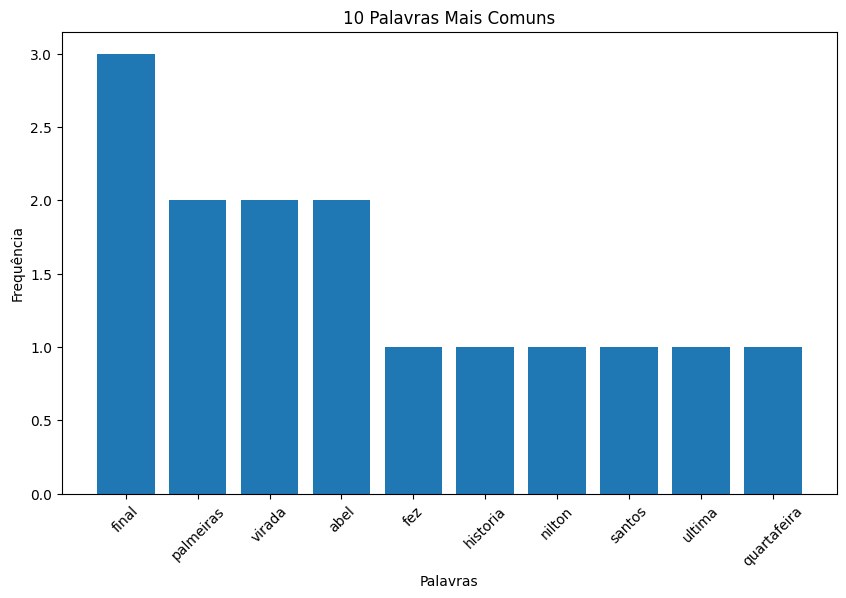

In [46]:
# Obter os 10 tokens mais comuns e suas contagens
tokens_mais_comuns = freq_dist.most_common(10)
palavras, contagens = zip(*tokens_mais_comuns)

# Gráfico de Barras
plt.figure(figsize=(10, 6))
plt.bar(palavras, contagens)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title('10 Palavras Mais Comuns')
plt.xticks(rotation=45)
plt.show()

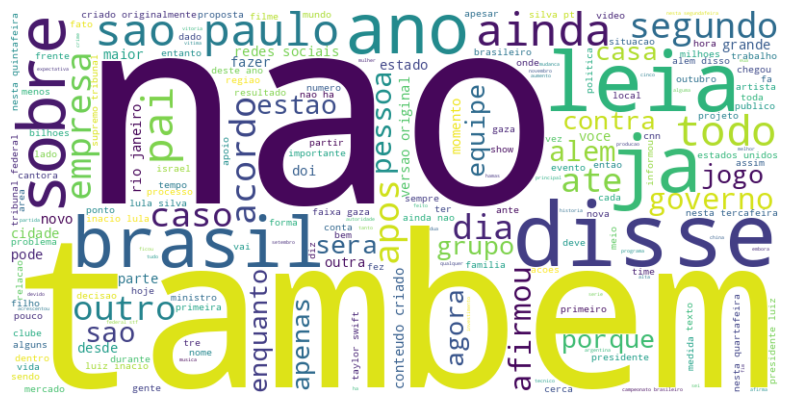

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join([' '.join(t) for t in token_text])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


### spaCy

In [49]:
from spacy.attrs import ORTH # Contagem de frequência de palavras usando Spacy

doc_sp = nlp(" ".join(token2[0]))

count_dict = doc_sp.count_by(ORTH)

In [50]:
sorted_counts = sorted(count_dict.items(), key=lambda item: item[1], reverse=True)

# 10 mais frequentes
top_10_frequent_words = sorted_counts[:10]

# Print
for word, count in top_10_frequent_words:
    print(nlp.vocab.strings[word], count)

palmeiras 2
virada 2
abel 2
historia 1
nilton 1
santos 1
ultima 1
quartafeira 1
partida 1
botafogo 1


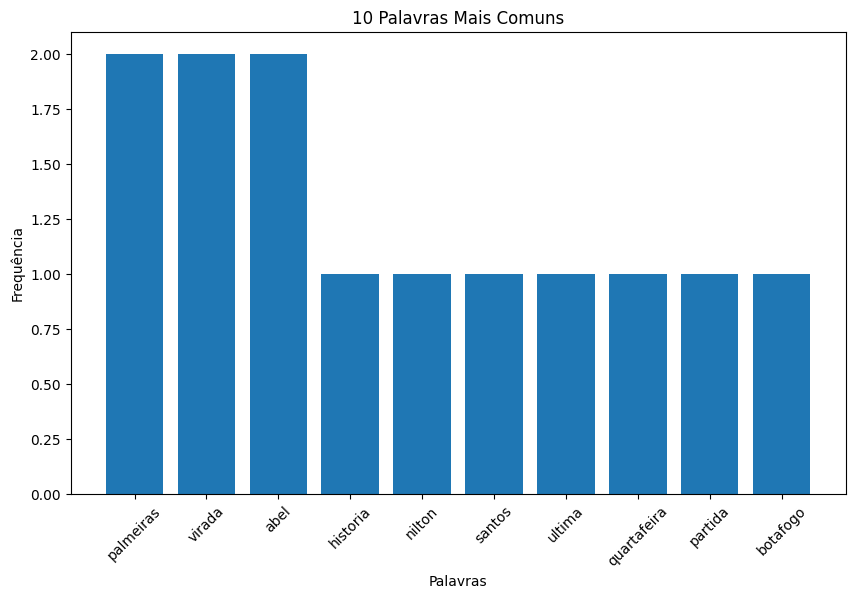

In [51]:
palavras = []
contagens = []
# Obter os 10 tokens mais comuns e suas contagens
for word, count in top_10_frequent_words:
    palavras.append(nlp.vocab.strings[word])
    contagens.append(count)

# Gráfico de Barras
plt.figure(figsize=(10, 6))
plt.bar(palavras, contagens)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title('10 Palavras Mais Comuns')
plt.xticks(rotation=45)
plt.show()

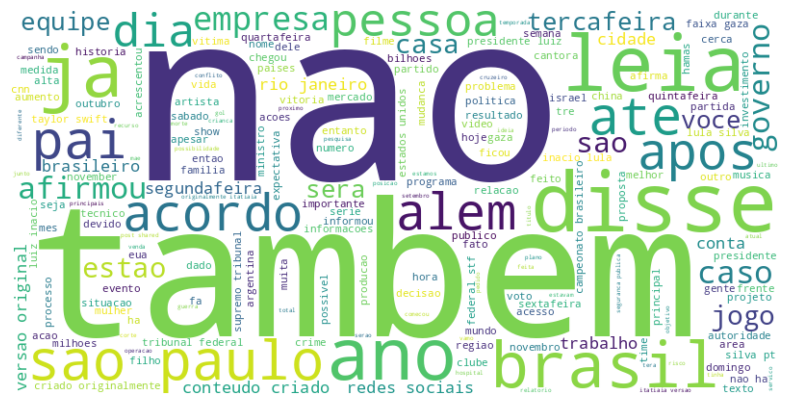

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join([' '.join(t) for t in token2])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Gensim

In [53]:
from gensim import corpora

dictionary = corpora.Dictionary(token3) 
corpus = [dictionary.doc2bow(text) for text in token3]
print(corpus[1])

[(9, 1), (21, 2), (25, 1), (29, 1), (55, 2), (56, 1), (57, 1), (58, 1), (59, 2), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 3), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 2), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 2), (108, 1), (109, 1), (110, 2), (111, 1), (112, 1), (113, 1), (114, 1), (115, 1), (116, 1), (117, 1), (118, 1), (119, 1), (120, 2), (121, 1), (122, 1)]


In [54]:
mapping = {v: k for k, v in dictionary.token2id.items()}
ttt = [[(mapping[i[0]], i[1]) for i in item] for item in corpus]
print(ttt[0])

[('abaixo', 1), ('abel', 2), ('acompanhar', 1), ('apesar', 1), ('aps', 1), ('assista', 1), ('bastidores', 1), ('botafogo', 1), ('brasileiro', 1), ('campeonato', 1), ('clima', 1), ('confiana', 1), ('contedo', 1), ('conversa', 1), ('criado', 1), ('decidido', 1), ('divulgados', 1), ('elenco', 1), ('encheu', 1), ('endrick', 1), ('estdio', 1), ('etapa', 1), ('ferreira', 1), ('funk', 1), ('futuro', 1), ('gols', 1), ('histria', 1), ('intervalo', 1), ('itatiaia', 1), ('leia', 1), ('liderada', 1), ('ltima', 1), ('nilton', 1), ('original', 1), ('originalmente', 1), ('palmeiras', 2), ('partida', 1), ('pde', 1), ('perdendo', 1), ('provocao', 1), ('quartafeira', 1), ('reta', 1), ('sada', 1), ('sair', 1), ('santos', 1), ('segovinha', 1), ('som', 1), ('srie', 1), ('time', 1), ('times', 1), ('torcedor', 1), ('verso', 1), ('virada', 2), ('vista', 1), ('vitria', 1)]


In [55]:
sorted_ttt = sorted(ttt[0], key=lambda x: x[1], reverse=True)

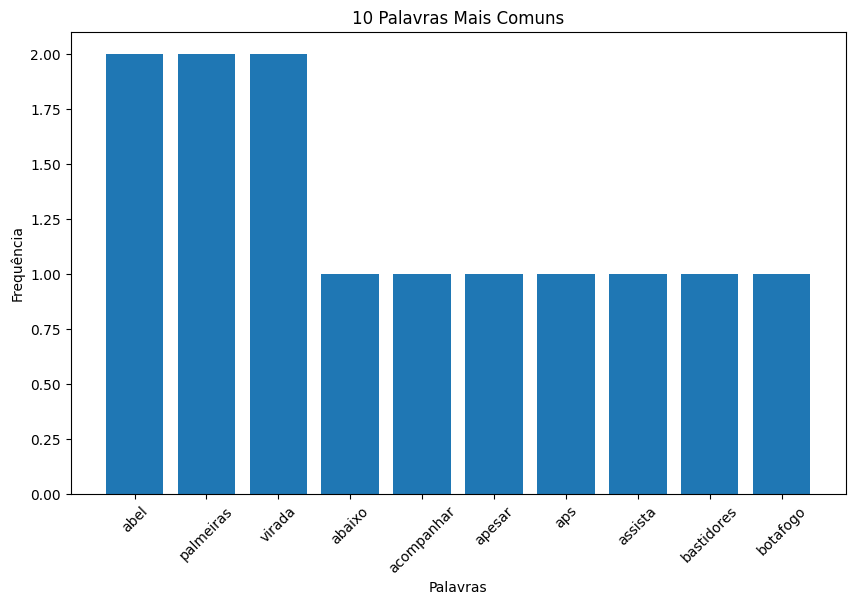

In [56]:
first_ten_elements = sorted_ttt[:10]

palavras = []
contagens = []
# Obter os 10 tokens mais comuns e suas contagens
for word, count in first_ten_elements:
    palavras.append(word)
    contagens.append(count)


# Gráfico de Barras
plt.figure(figsize=(10, 6))
plt.bar(palavras, contagens)
plt.xlabel('Palavras')
plt.ylabel('Frequência')
plt.title('10 Palavras Mais Comuns')
plt.xticks(rotation=45)
plt.show()

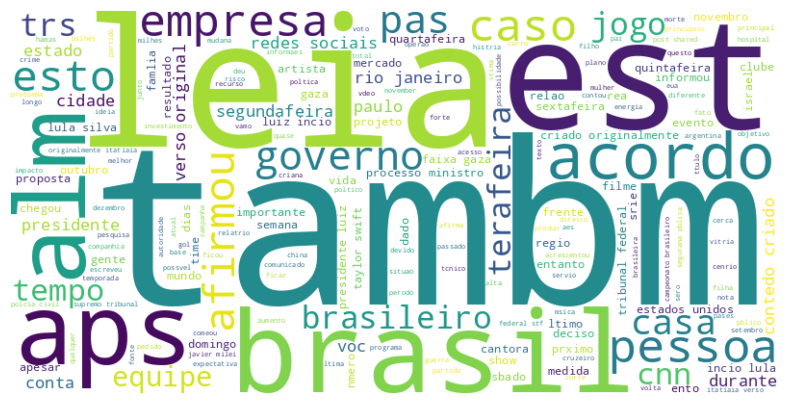

In [57]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join([' '.join(t) for t in token3])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()